In [1]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input,Dense,Reshape,Flatten,Conv2D,Conv2DTranspose,LeakyReLU,Dropout,Embedding,Concatenate,BatchNormalization
from keras.layers.core import Lambda
import tensorflow as tf
import numpy as np
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize
from keras.datasets import cifar10
from keras.callbacks import TensorBoard
import numpy


Using TensorFlow backend.


<Figure size 640x480 with 0 Axes>

In [0]:
from SpectralNormalizationKeras import DenseSN, ConvSN2D, ConvSN2DTranspose

In [0]:
def conv(x, channels, kernel=[1,1,1,1], stride=1):
  filter_size = 4
  input_channels = channels
  output_filters = channels
  x = tf.nn.conv2d(x, filters=tf.Variable(tf.truncated_normal([filter_size, filter_size, input_channels, output_filters], stddev=0.5)), strides=[1,1,1,1] , padding='SAME') 
  return x

def attention(query,key,value):
  dot_product=tf.matmul(query,key,transpose_b=True)
  weights=tf.nn.softmax(dot_product)
  x=tf.matmul(weights,value)
  return x

def self_attention_dis(x):
  H,W,C=16,16,256
  key_size=C // 8
  f=conv(x,key_size,1,1)
  g=conv(x,key_size,1,1)
  h=conv(x,C,1,1)
  o=attention(f,g,h)
  o=conv(o,C,1,1)

  with tf.variable_scope("gamma", reuse=tf.AUTO_REUSE):
    gamma = tf.get_variable("gamma", [1], initializer=tf.constant_initializer(0.0))  
  x = gamma * o + x

  return x

def self_attention_gen(x):
  H,W,C=16,16,128
  key_size=C // 8
  f=conv(x,key_size,1,1)
  g=conv(x,key_size,1,1)
  h=conv(x,C,1,1)
  o=attention(f,g,h)
  o=conv(o,C,1,1)

  with tf.variable_scope("gamma", reuse=tf.AUTO_REUSE):
    gamma = tf.get_variable("gamma", [1], initializer=tf.constant_initializer(0.0))  
  x = gamma * o + x

  return x

In [0]:
def discriminator_model(input_shape=(32,32,3), n_classes=10):
  input_label = Input(shape=(1,))
  label_ohv = Embedding(n_classes, 10)(input_label)
  dense_shape = input_shape[0] * input_shape[1] * input_shape[2]
  label_ohv = DenseSN(dense_shape)(label_ohv)
  label_ohv = Reshape((input_shape[0], input_shape[1], 3))(label_ohv)
  input_image = Input(shape=input_shape)
  img_label_merge = Concatenate()([input_image, label_ohv])
  mod = ConvSN2D(256, (3,3), strides=(2,2), padding='same')(img_label_merge)
  mod= LeakyReLU(alpha=0.3)(mod)
  mod = Lambda(self_attention_dis)(mod)
  mod = ConvSN2D(128, (3,3), strides=(2,2), padding='same')(mod)
  mod = LeakyReLU(alpha=0.3)(mod)
  mod = Flatten()(mod)
  mod = Dropout(0.4)(mod)
  out_layer = DenseSN(1, activation='sigmoid')(mod)
  model = Model([input_image, input_label], out_layer)
  opt = Adam(lr=0.0002, beta_1=0.0)
  model.compile(loss='categorical_hinge', optimizer=opt, metrics=['accuracy'])
  return model

In [5]:
discriminator=discriminator_model()
discriminator.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 10)        100         input_1[0][0]                    
__________________________________________________________________________________________________
dense_sn_1 (DenseSN)            (None, 1, 3072)      36864       embedding_1[0][0]                
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 32, 32, 3)    0                

In [0]:
def generator_model():
  classes=10
  input_label = Input(shape=(1,))
  label_ohv = Embedding(classes, 10)(input_label)
  dense_shape = 4 * 4
  label_ohv = Dense(dense_shape)(label_ohv)
  label_ohv = Reshape((4, 4, 1))(label_ohv)
  input_noise = Input(shape=(100,))
  dense_shape = 256 * 4 * 4
  mod = Dense(dense_shape)(input_noise)
  #mod = LeakyReLU(alpha=0.2)(mod)
  mod = Reshape((4, 4, 256))(mod)
  noise_label_merge = Concatenate()([mod, label_ohv])
  mod = Conv2DTranspose(256, (4,4), strides=(2,2), padding='same')(noise_label_merge)
 # mod = LeakyReLU(alpha=0.2)(mod)
  mod = BatchNormalization(epsilon=0.00005,momentum=0.1)(mod)
  mod = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(mod)
  mod = BatchNormalization(epsilon=0.00005,momentum=0.1)(mod)
  mod = LeakyReLU(alpha=0.2)(mod)
  mod = Lambda(self_attention_gen)(mod)
  mod = Conv2DTranspose(64, (4,4), strides=(2,2), padding='same')(mod)
  mod = LeakyReLU(alpha=0.2)(mod)
  out_layer = Conv2D(3, (7,7), activation='tanh', padding='same')(mod)
  model = Model([input_noise, input_label], out_layer)
  return model

In [7]:
generator=generator_model()
generator.summary()








Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 10)        100         input_3[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 4096)         413696      input_4[0][0]                    
_____________________________________________________________________________________

In [0]:
def gan_model():
  discriminator.trainable = False
  gen_noise, gen_label = generator.input
  gen_output = generator.output
  gan_output = discriminator([gen_output, gen_label])
  model = Model([gen_noise, gen_label], gan_output)
  opt = Adam(lr=0.0005, beta_1=0.0)
  model.compile(loss='categorical_hinge', optimizer=opt)
  return model

In [9]:
gan=gan_model()
gan.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 10)        100         input_3[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 4096)         413696      input_4[0][0]                    
____________________________________________________________________________________________

In [0]:
def load_and_normalize():
  (x_train, y_train), (_,_) = load_data()
  x_train = x_train.astype('float32')
  x_train=(x_train-127.5)/127.5
  print(x_train.shape)
  return [x_train,y_train]

In [0]:
def data_for_discriminator(data,batch_size):

  images,labels= data
  
  random = randint(0,images.shape[0] ,int(batch_size/2))
  real_f,real_l = images[random],labels[random]
  real_mainl = ones((int(batch_size/2), 1))
  
  input_dims=randn(100*int(batch_size/2))
  input_dims = input_dims.reshape(int(batch_size/2), 100)
  labels = randint(0, 10, int(batch_size/2))
  print(real_l.shape)
  print(labels.shape)
  
  fake_f = generator.predict([input_dims,labels])
  fake_l = zeros((int(batch_size/2), 1))

  return [real_f,real_l],real_mainl,[fake_f,labels],fake_l

In [0]:
def data_for_img_generation(generator,num_images):
  input_dims=randn(100*num_images)
  input_dims = input_dims.reshape(num_images,100)
  data_x = generator.predict(input_dims)
  data_y = zeros((num_images, 1))
  return data_x, data_y

In [0]:
def data_for_gan(batch_size):
  input_dims=randn(100*batch_size)
  train_gan_x= input_dims.reshape(batch_size, 100)
  labels = randint(0, 10, batch_size)
  return [train_gan_x,labels]

In [0]:
# def fid_cals(images1,images2):
# # scale an array of images to a new size
def scale_images(images, new_shape):
  images_list = list()
  for image in images:
    # resize with nearest neighbor interpolation
    new_image = resize(image, new_shape, 0)
    # store
    images_list.append(new_image)
  return asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
  # calculate activations
  act1 = model.predict(images1)
  act2 = model.predict(images2)
  # calculate mean and covariance statistics
  mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
  mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
  # calculate sum squared difference between means
  ssdiff = numpy.sum((mu1 - mu2)**2.0)
  # calculate sqrt of product between cov
  covmean = sqrtm(sigma1.dot(sigma2))
  # check and correct imaginary numbers from sqrt
  if iscomplexobj(covmean):
    covmean = covmean.real
  # calculate score
  fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
  return fid


In [0]:
def fid_check(epoch, generator, discriminator, gan,dataset, latent_dim, num_images=1000):
	
  filename = 'drive/My Drive/models/generator_model_%03d.h5' % (epoch+1)
  generator.save(filename)
  filename2 = 'drive/My Drive/models/discriminator_model_%03d.h5' % (epoch+1)
  discriminator.save(filename2)
  filename3 = 'drive/My Drive/models/gan_model_%03d.h5' % (epoch+1)
  gan.save(filename3)
  
  
  
  def save_plot(examples, n):
    # plot images
    for i in range(n * n):
      # define subplot
      pyplot.subplot(n, n, 1 + i)
      # turn off axis
      pyplot.axis('off')
      # plot raw pixel data
      pyplot.imshow(examples[i])
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()



  input_dims=randn(100*100)
  input_dims = input_dims.reshape(100,100)

  labels = randint(0, 10, 100)

  labels = asarray([x for _ in range(10) for x in range(10)])
  images  = generator.predict([input_dims, labels])
  images = (images + 1) / 2.0
  save_plot(images, 8)

 
  
  
  
  

  #x_fake, y_fake = data_for_img_generation(generator, num_images)

  model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
  #images1, y_fake = data_for_img_generation(generator, 1200)
  (_, _), (images2, _) = cifar10.load_data()
  images2=images2[:100]
  images2=(images2-127.5)/127.2
  images = images.astype('float32')
  images2 = images2.astype('float32')
  # resize images
  images = scale_images(images, (299,299,3))
  images2 = scale_images(images2, (299,299,3))
  print('Scaled', images.shape, images2.shape)
  # pre-process images
  #   images1 = preprocess_input(images1)
  #   images2 = preprocess_input(images2)
  # calculate fid
  fid = calculate_fid(model, images, images2)
  print('FID: %.3f' % fid)

In [0]:
def train(generator, discriminator, gan, batch_size, data, n_epochs=40):
  bat_per_epo = int(dataset[0].shape[0] / batch_size)
  epoch_arr=np.zeros((100,1))
  dis_loss=np.zeros((100,1))
  gen_loss=np.zeros((100,1))
  for i in range(n_epochs):
    for j in range(bat_per_epo):
      [train_real, train_reall], labreal,[train_fake,trainfakel],labfake=data_for_discriminator(dataset,batch_size)
      dr_loss, _ = discriminator.train_on_batch([train_real, train_reall], labreal)
      df_loss, _ = discriminator.train_on_batch([train_fake,trainfakel],labfake)
      d_loss=dr_loss + df_loss
      
      epoch_arr=np.append(epoch_arr,i)
  
      train_ganx,train_gany=data_for_gan(batch_size)
      y_gan = ones((batch_size, 1))   
      g_loss=gan.train_on_batch([train_ganx,train_gany],y_gan)
      gen_loss=np.append(gen_loss,g_loss)
      print('>%d, %d/%d, dloss=%.3f, gloss=%.3f' %
        (i+1, j+1, bat_per_epo, d_loss, g_loss))
    if (i+1) % 2 == 0:
      fid_check(i+1,generator,discriminator,gan,data,100)
    #generator.save('cgan_generator.h5')



In [18]:
latent_dim = 100

dataset = load_and_normalize()
# train model


(50000, 32, 32, 3)


In [19]:
train(generator, discriminator, gan,80, dataset)

(40, 1)
(40,)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 1/625, dloss=2.019, gloss=0.495
(40, 1)
(40,)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 2/625, dloss=2.037, gloss=0.507
(40, 1)
(40,)
>1, 3/625, dloss=2.026, gloss=0.498
(40, 1)
(40,)
>1, 4/625, dloss=2.036, gloss=0.481
(40, 1)
(40,)


KeyboardInterrupt: ignored

In [0]:
generator.save('sagan_generator.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Scaled (100, 299, 299, 3) (100, 299, 299, 3)
FID: 269.198


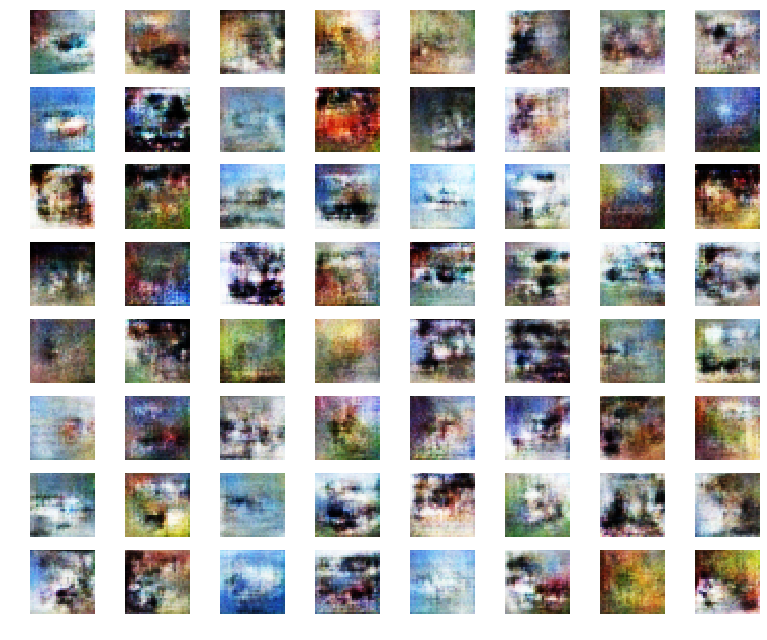

In [22]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

def save_plot(examples, n):
    # plot images
    for i in range(n * n):
      # define subplot
      pyplot.subplot(n, n, 1 + i)
      # turn off axis
      pyplot.axis('off')
      # plot raw pixel data
      pyplot.imshow(examples[i])
    pyplot.plot()


generator = load_model('sagan_generator.h5', custom_objects = {'conv':conv, 'tf':tf, 'attention':attention,'self_attention_gen':self_attention_gen})

input_dims=randn(100*100)
input_dims = input_dims.reshape(100,100)

labels = randint(0, 10, 100)

labels = asarray([x for _ in range(10) for x in range(10)])
images  = generator.predict([input_dims, labels])
images = (images + 1) / 2.0
save_plot(images, 8)







#x_fake, y_fake = data_for_img_generation(generator, num_images)

model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
#images1, y_fake = data_for_img_generation(generator, 1200)
(_, _), (images2, _) = cifar10.load_data()
images2=images2[:100]
images2=(images2-127.5)/127.2
images = images.astype('float32')
images2 = images2.astype('float32')
# resize images
images = scale_images(images, (299,299,3))
images2 = scale_images(images2, (299,299,3))
print('Scaled', images.shape, images2.shape)
# pre-process images
#   images1 = preprocess_input(images1)
#   images2 = preprocess_input(images2)
# calculate fid
fid = calculate_fid(model, images, images2)
print('FID: %.3f' % fid)


